In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_theme()
palette = sns.color_palette("viridis", as_cmap=True)
# palette = sns.color_palette("hsv", as_cmap=True)
# palette = sns.color_palette("Spectral", as_cmap=True)

- Download and compile [HypoDD](https://www.ldeo.columbia.edu/~felixw/hypoDD.html)
- Download test files from [Zhu et al. (2021)](https://arxiv.org/abs/2109.09008)
```bash
curl -O -J -L https://osf.io/aw53b/download
curl -O -J -L https://osf.io/y879e/download
```
- Convert GaMMA catalog and run HypoDD relocation
```
python gamma2hypodd.py
```

In [20]:
region_name = "Ridgecrest"
xlim = (-117.8, -117.3)
ylim = (35.5, 36.0)
zlim = (0, 15)
zlim_special = (0, 20)
size = 1.0
alpha = 0.5

# region_name = "PuertoRico"
# # xlim = (-68, -65)
# # ylim = (17, 19)
# xlim = (-67.2, -66.6)
# ylim = (17.75, 18.1)
# zlim = (0, 25)
# zlim_special = None
# size = 0.5
# alpha = 0.3

# region_name = "Hawaii"
# xlim = (-156.00, -154.75)
# ylim = (18.9, 19.8)
# zlim = (0, 40)
# zlim_special = None
# size = 1.0
# alpha = 0.5


In [3]:

# catalog_hypoinverse = pd.read_csv("catOut.sum", sep="\s+")
catalog_hypoDD = pd.read_csv(f"./{region_name}/hypoDD_catalog.txt", sep="\s+", names=["ID", "LAT", "LON", "DEPTH", "X", "Y", "Z", "EX", "EY", "EZ", "YR", "MO", "DY", "HR", "MI", "SC", "MAG", "NCCP", "NCCS", "NCTP",
"NCTS", "RCC", "RCT", "CID"])
catalog_hypoDD["time"] = catalog_hypoDD.apply(lambda x: f'{x["YR"]:04.0f}-{x["MO"]:02.0f}-{x["DY"]:02.0f}T{x["HR"]:02.0f}:{x["MI"]:02.0f}:{min(x["SC"], 59.999):05.3f}', axis=1)
catalog_hypoDD["time"] = catalog_hypoDD["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

catalog_gamma = pd.read_csv(f"./{region_name}/gamma_catalog.csv", sep="\t")
catalog_gamma["time"] = catalog_gamma["time"].apply(lambda x: datetime.strptime(x, "%Y-%m-%dT%H:%M:%S.%f"))

In [21]:
picks_gamma = pd.read_csv(f"./{region_name}/gamma_picks.csv", sep="\t")
print(f"Number of stations: {len(set(picks_gamma['id']))}")

Number of stations: 45


In [4]:
catalog_gamma["sigma"] = catalog_gamma["covariance"].apply(lambda x: float(x.split(",")[0]))
max_sigma = 1.0
catalog_gamma_selected = catalog_gamma[catalog_gamma["sigma"] < max_sigma]

In [5]:
c_gamma = (np.array(catalog_gamma_selected["time"]) - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
c_hypodd = (np.array(catalog_hypoDD["time"]) - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
t_gamma = catalog_gamma_selected["time"]
t_hypodd = catalog_hypoDD["time"]

/Users/weiqiang/.local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  """Entry point for launching an IPython kernel.
/Users/weiqiang/.local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


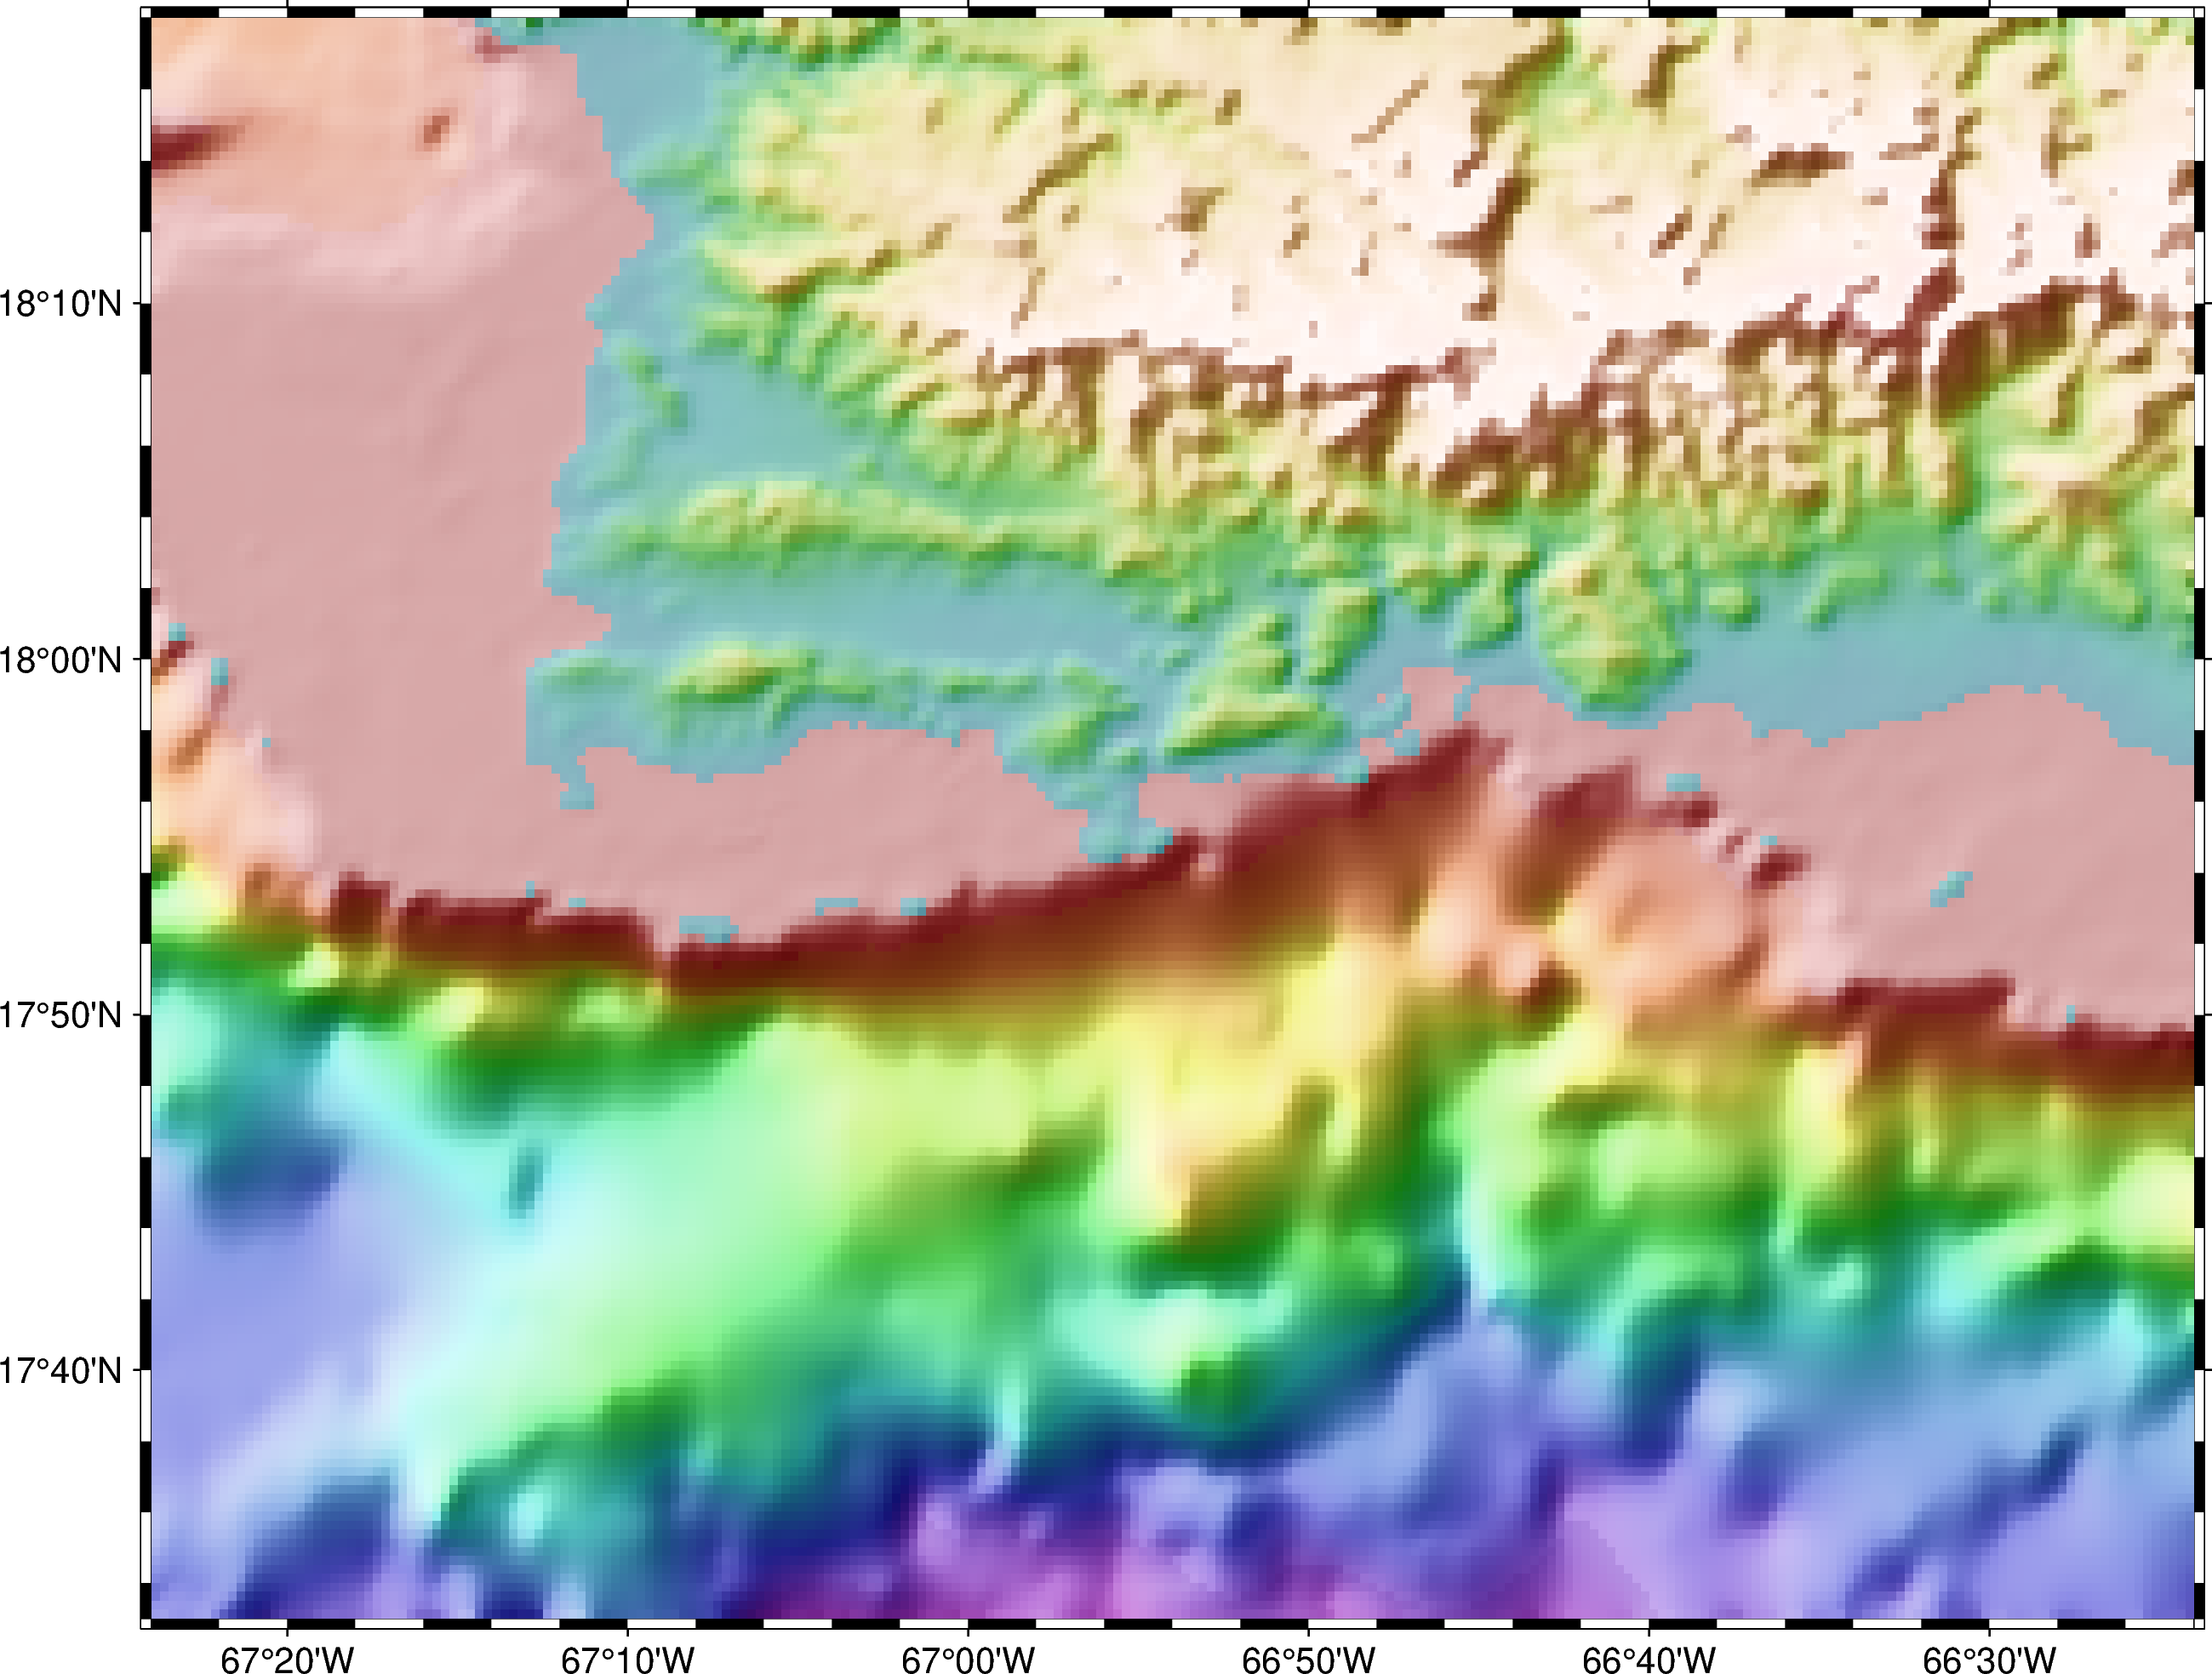

In [6]:
import pygmt
region = xlim + ylim
region = np.array(region) + np.array([-1, 1, -1, 1])*0.2
stations = pd.read_csv("stations.csv", sep="\t")
fig = pygmt.Figure()
fig.basemap(region=region, projection="M8i", frame=True)
fig.grdimage("@earth_relief_15s", cmap="topo", shading=True)
# fig.grdimage("@earth_relief_15s", cmap="sealand", shading=True)
# fig.plot(x=stations["longitude"], y=stations["latitude"], style="t0.5", color="blue", pen="black", label="Station")
fig.savefig(f"{region_name}/topography.pdf")
fig.savefig(f"{region_name}/topography.png")
fig.show()

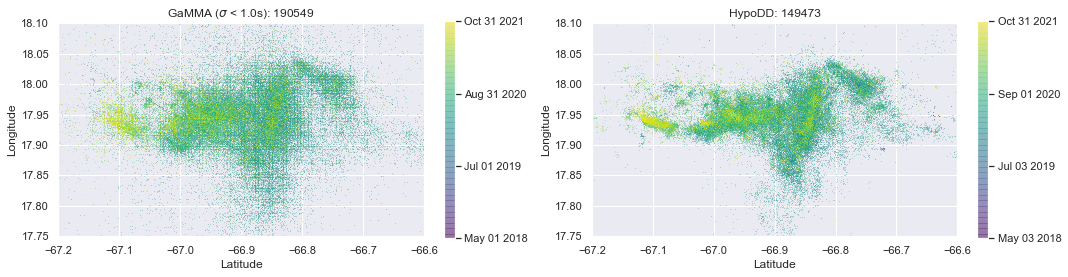

In [7]:
plt.figure(figsize=(15, 6))

im_ratio = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])

plt.subplot(121)
plt.scatter(catalog_gamma_selected["longitude"], catalog_gamma_selected["latitude"], s=size, c=c_gamma, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"GaMMA ($\sigma$ < {max_sigma:.1f}s): {len(catalog_gamma_selected)}")
plt.axis("scaled")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Latitude")
plt.ylabel("Longitude")

cbar = plt.colorbar(fraction=0.047*im_ratio)
cbar.set_ticks(np.linspace(c_gamma.min(), c_gamma.max(), 4))
cbar.ax.set_yticklabels([pd.to_datetime(x, unit='s').strftime('%b %d %Y') for x in np.linspace(t_gamma.min().timestamp(), t_gamma.max().timestamp(), 4)])


plt.subplot(122)
plt.scatter(catalog_hypoDD["LON"], catalog_hypoDD["LAT"], s=size, c=c_hypodd, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"HypoDD: {len(catalog_hypoDD)}")
plt.axis("scaled")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Latitude")
plt.ylabel("Longitude")

cbar = plt.colorbar(fraction=0.047*im_ratio)
cbar.set_ticks(np.linspace(c_hypodd.min(), c_hypodd.max(), 4))
cbar.ax.set_yticklabels([pd.to_datetime(x, unit='s').strftime('%b %d %Y') for x in np.linspace(t_hypodd.min().timestamp(), t_hypodd.max().timestamp(), 4)])

plt.tight_layout()

plt.savefig(f"{region_name}/GaMMA2HypoDD_latitude_vs_longitude_color_by_time.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{region_name}/GaMMA2HypoDD_latitude_vs_longitude_color_by_time.png", bbox_inches="tight", dpi=600)
plt.show()

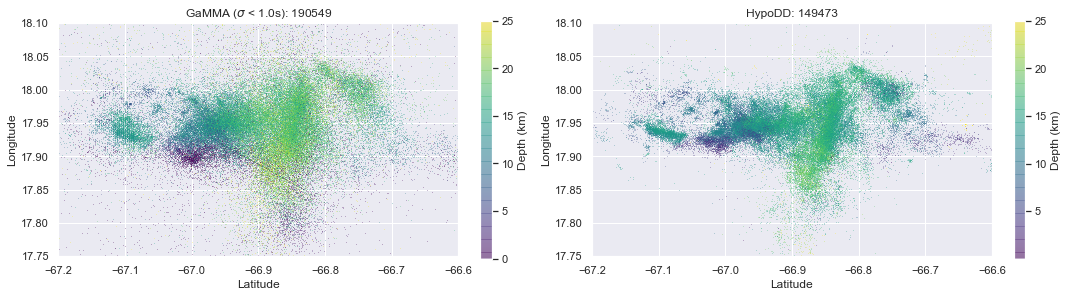

In [8]:
plt.figure(figsize=(15, 6))

im_ratio = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])

c = catalog_gamma_selected["depth(m)"].copy()/1e3
c[c<zlim[0]] = zlim[0]
if zlim_special is None:
    c[c>zlim[1]] = zlim[1]
else:
    c[c>zlim_special[1]] = zlim_special[1]

plt.subplot(121)
plt.scatter(catalog_gamma_selected["longitude"], catalog_gamma_selected["latitude"], s=size, c=c, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"GaMMA ($\sigma$ < {max_sigma:.1f}s): {len(catalog_gamma_selected)}")
plt.axis("scaled")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.colorbar(label="Depth (km)", fraction=0.047*im_ratio)

c = catalog_hypoDD["DEPTH"].copy()
c[c<zlim[0]] = zlim[0]
c[c>zlim[1]] = zlim[1]

plt.subplot(122)
im = plt.scatter(catalog_hypoDD["LON"], catalog_hypoDD["LAT"], s=size, c=c, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"HypoDD: {len(catalog_hypoDD)}")
plt.axis("scaled")
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.colorbar(label="Depth (km)", fraction=0.047*im_ratio)

plt.tight_layout()

plt.savefig(f"{region_name}/GaMMA2HypoDD_latitude_vs_longitude_color_by_depth.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{region_name}/GaMMA2HypoDD_latitude_vs_longitude_color_by_depth.png", bbox_inches="tight", dpi=600)
plt.show()

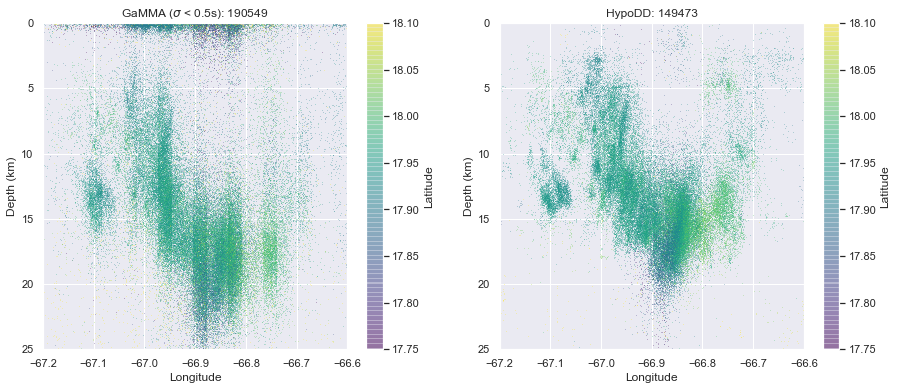

In [9]:
# plt.figure(figsize=(15, 6))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

c = catalog_gamma_selected["latitude"].copy()
c[c < ylim[0]] = ylim[0]
c[c > ylim[1]] = ylim[1]

ax = axes[0]
im = ax.scatter(catalog_gamma_selected["longitude"], catalog_gamma_selected["depth(m)"]/1e3, s=size, c=c, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
ax.set_title(f"GaMMA ($\sigma$ < 0.5s): {len(catalog_gamma_selected)}")
ax.set_xlim(xlim)
if zlim_special is None:
    ax.set_ylim(zlim)
else:
    ax.set_ylim(zlim_special)
ax.set_xlabel("Longitude")
ax.set_ylabel("Depth (km)")
ax.invert_yaxis()
fig.colorbar(im, ax=ax, label="Latitude")

c = catalog_hypoDD["LAT"].copy()
c[c < ylim[0]] = ylim[0]
c[c > ylim[1]] = ylim[1]

ax = axes[1]
im = ax.scatter(catalog_hypoDD["LON"], catalog_hypoDD["DEPTH"], s=size, c=c, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
ax.set_title(f"HypoDD: {len(catalog_hypoDD)}")
ax.set_xlim(xlim)
ax.set_ylim(zlim)
ax.set_xlabel("Longitude")
ax.set_ylabel("Depth (km)")
ax.invert_yaxis()
fig.colorbar(im, ax=ax, label="Latitude")

# fig.colorbar(im, ax=axes.ravel().tolist(), label="Latitude")

plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_longitude_color_by_latitude.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_longitude_color_by_latitude.png", bbox_inches="tight", dpi=600)
plt.show()

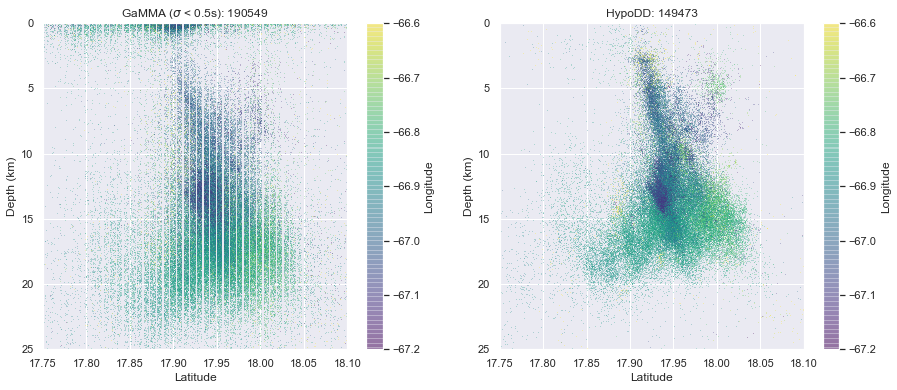

In [10]:
plt.figure(figsize=(15, 6))

c = catalog_gamma_selected["longitude"].copy()
c[c < xlim[0]] = xlim[0]
c[c > xlim[1]] = xlim[1]
plt.subplot(121)
plt.scatter(catalog_gamma_selected["latitude"], catalog_gamma_selected["depth(m)"]/1e3, c=c, s=size, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"GaMMA ($\sigma$ < 0.5s): {len(catalog_gamma_selected)}")
plt.xlim(ylim)
if zlim_special is None:
    plt.ylim(zlim)
else:
    plt.ylim(zlim_special)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.colorbar(label="Longitude")

c = catalog_hypoDD["LON"].copy()
c[c < xlim[0]] = xlim[0]
c[c > xlim[1]] = xlim[1]
plt.subplot(122)
plt.scatter(catalog_hypoDD["LAT"], catalog_hypoDD["DEPTH"], s=size, c=c, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"HypoDD: {len(catalog_hypoDD)}")
plt.xlim(ylim)
plt.ylim(zlim)
plt.gca().invert_yaxis()
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
plt.colorbar(label="Longitude")

plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_latitude_color_by_longitude.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_latitude_color_by_longitude.png", bbox_inches="tight", dpi=600)
plt.show()

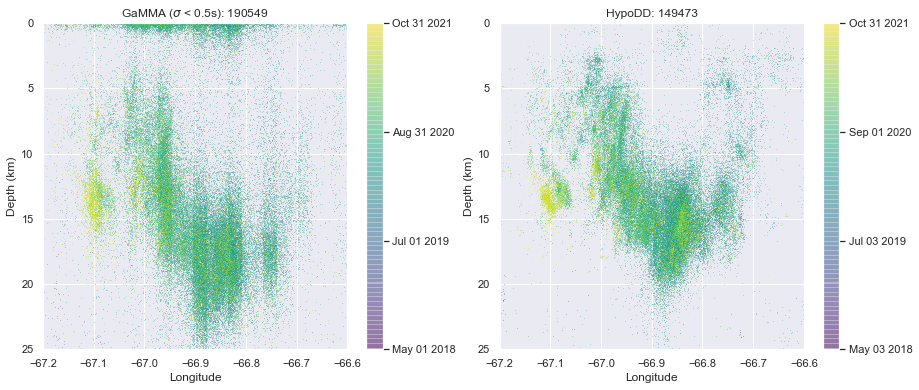

In [11]:
import matplotlib.dates as mdates
plt.figure(figsize=(15, 6))

# t_gamma = mdates.epoch2num(t_gamma)
# t_hypodd = mdates.epoch2num(t_hypodd)
# t_gamma = mdates.datetime(t_gamma)

c = catalog_gamma_selected["latitude"].copy()
c[c < ylim[0]] = ylim[0]
c[c > ylim[1]] = ylim[1]

plt.subplot(121)
plt.scatter(catalog_gamma_selected["longitude"], catalog_gamma_selected["depth(m)"]/1e3, s=size, c=c_gamma, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"GaMMA ($\sigma$ < 0.5s): {len(catalog_gamma_selected)}")
plt.xlim(xlim)
if zlim_special is None:
    plt.ylim(zlim)
else:
    plt.ylim(zlim_special)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(c_gamma.min(), c_gamma.max(), 4))
cbar.ax.set_yticklabels([pd.to_datetime(x, unit='s').strftime('%b %d %Y') for x in np.linspace(t_gamma.min().timestamp(), t_gamma.max().timestamp(), 4)])


c = catalog_hypoDD["LAT"].copy()
c[c < ylim[0]] = ylim[0]
c[c > ylim[1]] = ylim[1]
plt.subplot(122)
plt.scatter(catalog_hypoDD["LON"], catalog_hypoDD["DEPTH"], s=size, c=c_hypodd, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"HypoDD: {len(catalog_hypoDD)}")
plt.xlim(xlim)
plt.ylim(zlim)
plt.gca().invert_yaxis()
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(c_hypodd.min(), c_hypodd.max(), 4))
cbar.ax.set_yticklabels([pd.to_datetime(x, unit='s').strftime('%b %d %Y') for x in np.linspace(t_hypodd.min().timestamp(), t_hypodd.max().timestamp(), 4)])

plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_longitude_color_by_time.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_longitude_color_by_time.png", bbox_inches="tight", dpi=600)
plt.show()

In [12]:
zlim_special

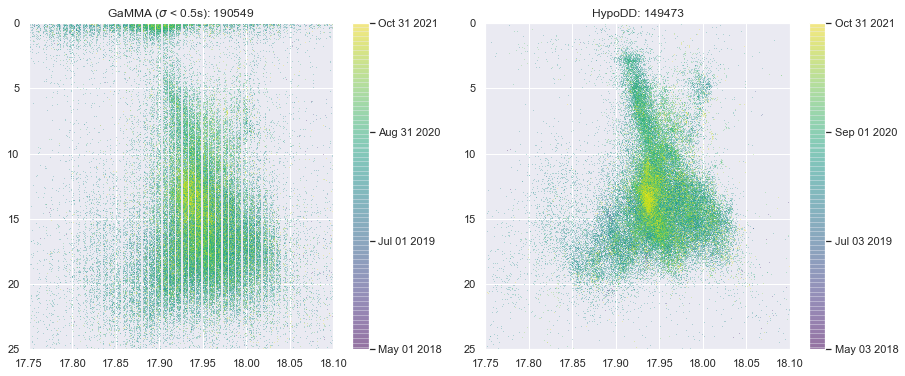

In [13]:
plt.figure(figsize=(15, 6))

c = catalog_gamma_selected["longitude"].copy()
c[c < xlim[0]] = xlim[0]
c[c > xlim[1]] = xlim[1]
plt.subplot(121)
plt.scatter(catalog_gamma_selected["latitude"], catalog_gamma_selected["depth(m)"]/1e3, c=c_gamma, s=size, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"GaMMA ($\sigma$ < 0.5s): {len(catalog_gamma_selected)}")
plt.xlim(ylim)
if zlim_special is None:
    plt.ylim(zlim)
else:
    plt.ylim(zlim_special)
plt.gca().invert_yaxis()

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(c_gamma.min(), c_gamma.max(), 4))
cbar.ax.set_yticklabels([pd.to_datetime(x, unit='s').strftime('%b %d %Y') for x in np.linspace(t_gamma.min().timestamp(), t_gamma.max().timestamp(), 4)])


c = catalog_hypoDD["LON"].copy()
c[c < xlim[0]] = xlim[0]
c[c > xlim[1]] = xlim[1]
plt.subplot(122)
plt.scatter(catalog_hypoDD["LAT"], catalog_hypoDD["DEPTH"], s=size, c=c_hypodd, alpha=alpha, marker=",", cmap=palette, linewidth=0, rasterized=True)
plt.title(f"HypoDD: {len(catalog_hypoDD)}")
plt.xlim(ylim)
plt.ylim(zlim)
plt.gca().invert_yaxis()

cbar = plt.colorbar()
cbar.set_ticks(np.linspace(c_hypodd.min(), c_hypodd.max(), 4))
cbar.ax.set_yticklabels([pd.to_datetime(x, unit='s').strftime('%b %d %Y') for x in np.linspace(t_hypodd.min().timestamp(), t_hypodd.max().timestamp(), 4)])

plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_latitude_color_by_time.pdf", bbox_inches="tight", dpi=600)
plt.savefig(f"{region_name}/GaMMA2HypoDD_depth_vs_latitude_color_by_time.png", bbox_inches="tight", dpi=600)
plt.show()